<a href="https://colab.research.google.com/github/bt22dr/deep-learning-papers/blob/master/code/WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 캐글에서 LJSpeech-1.1 데이터 다운로드

참조 : https://colab.research.google.com/drive/1DofKEdQYaXmDWBzuResXWWvxhLgDeVyl#scrollTo=akJ8fvsfGVdn

In [0]:
from google.colab import files
files.upload()

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
!kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
#!kaggle datasets list -s ljspeech
!kaggle datasets download -d dromosys/ljspeech

100% 2.56G/2.56G [01:10<00:00, 53.8MB/s]
100% 2.56G/2.56G [01:10<00:00, 39.0MB/s]


In [0]:
!unzip /content/ljspeech.zip
!tar -xjf /content/LJSpeech-1.1.tar.bz2

Archive:  /content/ljspeech.zip
  inflating: LJSpeech-1.1.tar.bz2    


In [0]:
!ls /content/LJSpeech-1.1/
!head /content/LJSpeech-1.1/metadata.csv
!tail /content/LJSpeech-1.1/metadata.csv
#!cat /content/LJSpeech-1.1/README

ls: cannot access '/content/LJSpeech-1.1/': No such file or directory
head: cannot open '/content/LJSpeech-1.1/metadata.csv' for reading: No such file or directory
tail: cannot open '/content/LJSpeech-1.1/metadata.csv' for reading: No such file or directory


## WaveNet 

참고 : 
* WaveNet 구현:
  * https://github.com/modulabs/Deep-Generative-Models/blob/master/1st/3.Autoregressive%20Models%20-%20Practice/wavenet.ipynb
  * https://github.com/ibab/tensorflow-wavenet
* Conv1D
  * https://missinglink.ai/guides/deep-learning-frameworks/keras-conv1d-working-1d-convolutional-neural-networks-keras/

In [36]:
# Install TensorFlow
#!pip install tf-nightly-2.0-preview
#!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow-gpu

!pip install --upgrade tensorflow-probability
#!pip install tfp-nightly

!pip install librosa

Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.6.0)


In [0]:
import librosa
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfd = tf.contrib.distributions
layers = tf.keras.layers

tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.13.1
Eager execution: True


In [0]:
# sample_rate = 22050
sample_rate = 16000
mu = 256

In [0]:
# from os import listdir
# from os.path import isfile, join
# import ntpath

# data_dir = '/content/LJSpeech-1.1/wavs'
# data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.wav' in f]

# def get_patches_from_LJSpeech(batch, time_length, sample_rate=sample_rate):
    
#     read_length = 0
#     waves = []
#     while(read_length < batch * time_length):
#         file_index = np.random.randint(0, len(data_files), 1)[0]
#         wav, _ = librosa.core.load(data_files[file_index], sr=sample_rate)
#         need_length = batch * time_length - read_length
        
#         if len(wav) > need_length:
#             wav = wav[:need_length]
            
#         read_length += len(wav)
#         waves.append(wav)
        
#     waves = np.concatenate(waves)
#     waves = np.reshape(waves, [batch, time_length])
    
#     return waves
  
# lj_data = get_patches_from_LJSpeech(10, sample_rate)
# print(lj_data.shape)

# plt.figure(figsize=[20, 3])
# plt.plot(lj_data[0])
# plt.show()

In [0]:
# import IPython.display as ipd
# ipd.Audio(lj_data[0], rate=sample_rate)

5586 165586
(10, 16000)


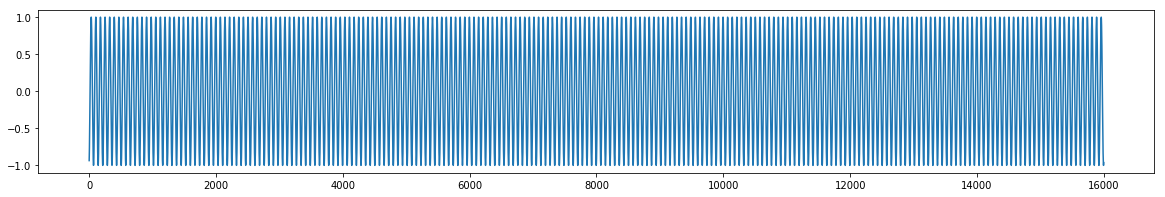

In [42]:
duration = 11.0  # in seconds
f = 220.0        # sine frequency, Hz
sine_wave = np.sin(2*np.pi*np.arange(sample_rate*duration)*f/sample_rate)

def get_sine_wave(batch, time_length):
    start_index = np.random.randint(0, len(sine_wave) - (batch * time_length), 1)[0]
    end_index = start_index + (batch * time_length)
    data = sine_wave[start_index:end_index]
    data = np.reshape(data, [batch, time_length])
    
    print(start_index, end_index)
    return data

sin_data = get_sine_wave(10, int(sample_rate))
print(sin_data.shape)

plt.figure(figsize=[20, 3])
plt.plot(sin_data[0])
plt.show()

(10, 16000)  => (10 waves, 16000 x 1.0 sec)


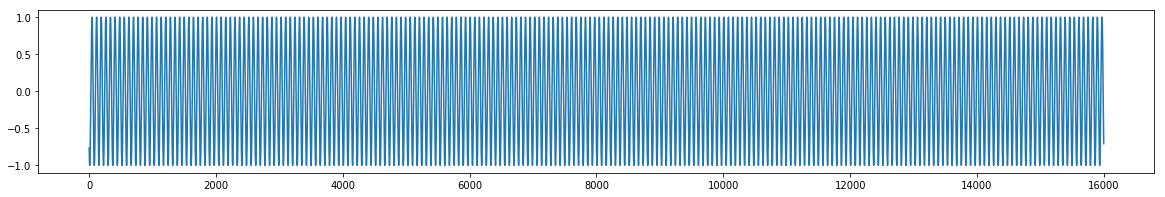

In [43]:
def get_sine_waves(N, sec, freq, sample_rate):
  duration = sec*2
  sine_wave = np.sin(2*np.pi*np.arange(sample_rate*duration)*freq/sample_rate)
  waves = []
  for i in range(N):
    start_index = np.random.randint(0, sec*sample_rate, 1)[0]
    end_index = start_index + int(sec*sample_rate)
    data = sine_wave[start_index:end_index]
    waves.append(data)
  waves = np.concatenate(waves)
  waves = np.reshape(waves, [N, -1])
  return waves

sec=1.0
N = 10
sin_data = get_sine_waves(N=N, sec=sec, freq=220.0, sample_rate=sample_rate)
print(sin_data.shape, " => ({} waves, {} x {} sec)".format(N, sample_rate, sec))

plt.figure(figsize=[20, 3])
plt.plot(sin_data[0])
plt.show()

In [44]:
import IPython.display as ipd
ipd.Audio(sin_data[0], rate=sample_rate)

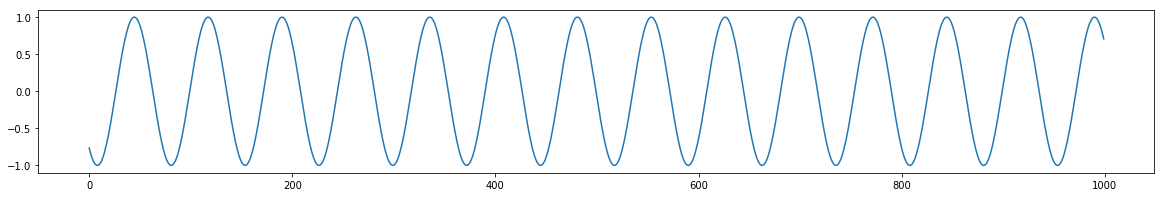

In [45]:
plt.figure(figsize=[20, 3])
plt.plot(sin_data[0][:1000])
plt.show()

### $\mu$-law companding


In [0]:
def mulaw(x, Mu):
    return tf.sign(x) * tf.math.log(1. + Mu * tf.abs(x)) / tf.cast(tf.math.log(1. + Mu), tf.float64)

def inv_mulaw(x, Mu):
    return tf.sign(x) * (1. / Mu) * (tf.pow(tf.cast(1. + Mu, tf.float64), tf.cast(tf.abs(x), tf.float64)) - 1.)

def onehot_index(x, minimum, maximum, Mu):
    return tf.clip_by_value(tf.cast((x - minimum) / (maximum - minimum) * Mu, tf.int32), 0, Mu - 1)

def inv_onehot_index(x, minimum, maximum, Mu):
    return x / Mu * (maximum - minimum) + minimum

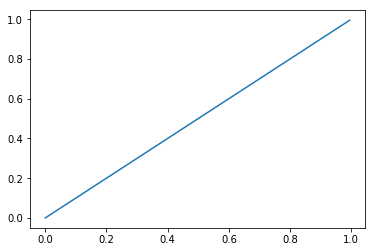

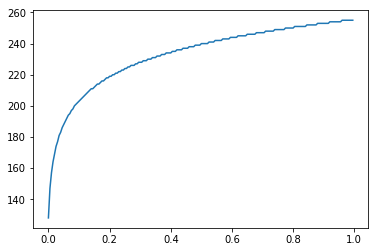

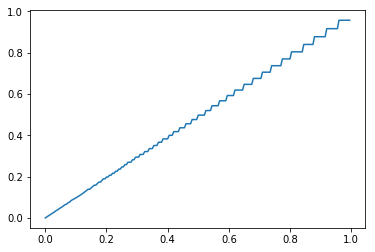

In [47]:
x = np.arange(0, 1, 0.005)
plt.figure(); plt.plot(x, x)

x_mulaw = mulaw(x, 256)
#plt.figure(); plt.plot(x, x_mulaw)

x_quantized = onehot_index(x_mulaw, -1, 1, 256)
plt.figure(); plt.plot(x, x_quantized)

x_inv = inv_onehot_index(x_quantized, -1, 1, 256)
#plt.figure(); plt.plot(x, x_inv)

x_recon = inv_mulaw(x_inv, 256)
plt.figure(); plt.plot(x, x_recon)

In [0]:
def mu_law_encode(audio, quantization_channels):
    '''Quantizes waveform amplitudes.'''
    with tf.name_scope('encode'):
        mu = tf.cast(quantization_channels - 1, tf.float64)
        # Perform mu-law companding transformation (ITU-T, 1988).
        # Minimum operation is here to deal with rare large amplitudes caused
        # by resampling.
        safe_audio_abs = tf.minimum(tf.abs(audio), 1.0)
        magnitude = tf.math.log1p(mu * safe_audio_abs) / tf.math.log1p(mu)
        signal = tf.sign(audio) * magnitude
        # Quantize signal to the specified number of levels.
        return tf.cast((signal + 1) / 2 * mu + 0.5, tf.int32)


def mu_law_decode(output, quantization_channels):
    '''Recovers waveform from quantized values.'''
    with tf.name_scope('decode'):
        mu = quantization_channels - 1
        # Map values back to [-1, 1].
        signal = 2 * (tf.cast(output, tf.float64) / mu) - 1
        # Perform inverse of mu-law transformation.
        magnitude = (1 / mu) * ((1 + mu)**abs(signal) - 1)
        return tf.sign(signal) * magnitude

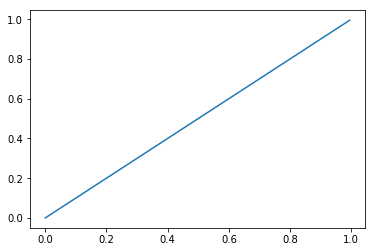

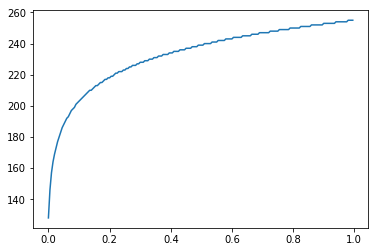

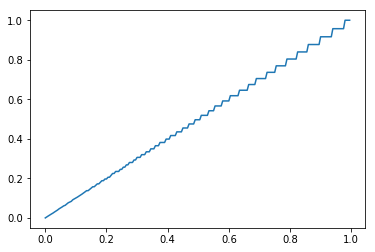

In [49]:
plt.figure(); plt.plot(x, x)

x_mu_law = mu_law_encode(x, 256)
plt.figure(); plt.plot(x, x_mu_law)

x_recon = mu_law_decode(x_mu_law, 256)
plt.figure(); plt.plot(x, x_recon)

In [0]:
# from tensorflow.keras.layers import Conv1D

# x = tf.expand_dims(sin_data, -1)
# print(x.shape)
# y = Conv1D(16, 2, dilation_rate=8, padding="causal")(x)
# print(y.shape)

In [0]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import Model

filter_width = 2
skip_channels = 64 # 256
residual_channels = 128 # 512
dilation_channels = 32
initial_filter_width = 32
quantization_channels = 256
post_proc_channels = 256
dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             # 1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             # 1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             # 1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

class WaveNet(tf.keras.Model):
  def __init__(self, dilations):
    super(WaveNet, self).__init__()
    
    # pre-process
    self.conv1 = Conv1D(
        filters=residual_channels, kernel_size=2, strides=1, padding='causal')
    
    # dilated conv stack
    self.filters = {dilation: Conv1D(filters=dilation_channels, 
                          kernel_size=2, strides=1, padding='causal',
                          dilation_rate=dilation) for dilation in dilations}
    self.gates = {dilation: Conv1D(filters=dilation_channels, 
                          kernel_size=2, strides=1, padding='causal', 
                          dilation_rate=dilation) for dilation in dilations}
    
    # post-process
    self.post_conv_1 = Conv1D(
        post_proc_channels, kernel_size=1, strides=1, padding="SAME")
    self.post_conv_2 = Conv1D(
        quantization_channels, kernel_size=1, strides=1, padding="SAME")

  def call(self, input):
    # input => shape: [batch_size, time_steps, 1]
    # print("input", input.shape)
    
    # 1. Pre-process : causal convolution
    ######################################
    x = self.conv1(input) 
    # => shape: [batch_size, time_steps, 512]
    # print("x", x.shape)
    
    # 2. Dilated conv layers
    ######################################
    skips = []
    for dilation in dilations:
      conv_filter = self.filters[dilation](x)
      conv_gate = self.gates[dilation](x)
      # conv_* => shape: [batch_size, time_steps, 32]
      
      z = tf.math.tanh(conv_filter) * tf.math.sigmoid(conv_gate)
      # z => shape: [batch_size, time_steps, 32]
      
      # residual output => shape: [batch_size, time_steps, 512]
      transformed = Conv1D(
          filters=residual_channels, kernel_size=2, strides=1, 
          dilation_rate=dilation, padding='causal', name="residual")(z)
      
      # skip output => shape: [batch_size, time_steps, 256]
      skip_contrib = Conv1D(
          filters=skip_channels, kernel_size=2, strides=1, 
          dilation_rate=dilation, padding='causal', name="skip")(z)
      
      skip, x = skip_contrib, x + transformed 
      # skip => shape: [batch_size, time_steps, 256]
      # x => shape: [batch_size, time_steps, 512]
      
      skips.append(skip)
      
    # 3. Post-process: (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv
    ######################################
    
    # aggregate skip connections => shape: [batch_size, time_steps, 256]
    total = sum(skips)
    
    # post-process 1 => shape: [batch_size, time_steps, 256]
    transformed1 = tf.keras.activations.relu(total)
    post_conv1 = self.post_conv_1(transformed1)
    
    # post-process 2 => shape: [batch_size, time_steps, 256]
    transformed2 = tf.keras.activations.relu(post_conv1)
    post_conv2 = self.post_conv_2(transformed2)
    
    # output => shape: [batch_size, time_steps, 256]
    return post_conv2

wavenet_model = WaveNet(dilations=dilations)

In [52]:
sec=1.0
N = 1
sine_data = get_sine_waves(N=N, sec=sec, freq=220.0, sample_rate=sample_rate)
sine_data = mu_law_encode(sine_data, 256)
print(sine_data.shape, " => ({} batches, {} x {} sec)".format(N, sample_rate, sec))

train_data = tf.cast(tf.expand_dims(sine_data, -1), tf.float32)
print("input shape:", train_data.shape)
out = wavenet_model(train_data)
print("output shape:", out.shape)
# wavenet_model.summary()

(1, 16000)  => (1 batches, 16000 x 1.0 sec)
input shape: (1, 16000, 1)
output shape: (1, 16000, 256)


[ 40 221 120 120 120 120 120 120 120 120]
tf.Tensor(
[-0.17234645  0.2249029  -0.00151245 -0.00151245 -0.00151245 -0.00151245
 -0.00151245 -0.00151245 -0.00151245 -0.00151245], shape=(10,), dtype=float64)


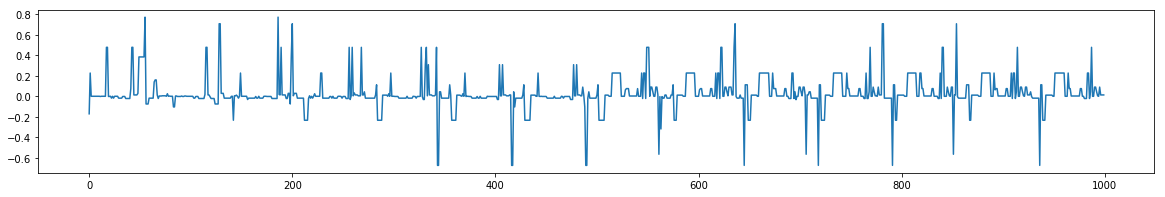

In [53]:
output = np.argmax(out[0], axis=1)
output_wav = mu_law_decode(output, 256)
print(output[:10])
print(output_wav[:10])

x = np.arange(0, 16000)
plt.figure(figsize=[20, 3]); plt.plot(x[:1000], output_wav.numpy()[:1000])

In [54]:
import IPython.display as ipd
ipd.Audio(output_wav, rate=sample_rate)

In [55]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

sec=1.0
batch_size = 1
sine_data = get_sine_waves(N=1, sec=sec, freq=220.0, sample_rate=sample_rate)

train_data = tf.cast(tf.expand_dims(sine_data, -1), tf.float32)
target_data = mu_law_encode(sine_data, 256)

l = loss(wavenet_model, train_data, target_data)
print("Loss test: {}".format(l))

Loss test: 5.533472537994385


In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [57]:
global_step = tf.Variable(0)
loss_value, grads = grad(wavenet_model, train_data, target_data)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

Step: 0, Initial Loss: 5.5503153800964355


In [58]:
sec=1.0
batch_size = 2
sine_data = get_sine_waves(N=100, sec=sec, freq=220.0, sample_rate=sample_rate)

# for train
N = len(sine_data)
train_dataset = tf.data.Dataset.from_tensor_slices(sine_data)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<DatasetV1Adapter shapes: (2, 16000), types: tf.float64>


In [59]:
def generator_sine_wave(batch_size, sec, freq, sample_rate):
  duration = sec*2
  sine_wave = np.sin(2*np.pi*np.arange(sample_rate*duration)*freq/sample_rate)
  waves = []
  for i in range(batch_size):
    start_index = np.random.randint(0, sec*sample_rate, 1)[0]
    end_index = start_index + int(sec*sample_rate)
    data = sine_wave[start_index:end_index]
    waves.append(data)
  waves = np.concatenate(waves)
  waves = np.reshape(waves, [batch_size, -1])
  
  yield waves

sec = 1.0
batch_size = 10
sine_data = generator_sine_wave(batch_size=batch_size, sec=sec, freq=220.0, sample_rate=sample_rate)
print(sine_data)

<generator object generator_sine_wave at 0x7fbcf1600fc0>


In [60]:
batch_size = 2
sec = 1.0
freq = 220.0
train_dataset = tf.data.Dataset.from_generator(generator_sine_wave, tf.float64, output_shapes=(None, sample_rate), args=(batch_size, sec, freq, sample_rate))
train_dataset = train_dataset.repeat()
print(train_dataset)

for d in train_dataset:
  print(d.shape)
  break

<DatasetV1Adapter shapes: (?, 16000), types: tf.float64>
(2, 16000)


In [88]:
train_loss_results = []

learning_rate=tf.train.exponential_decay(
            learning_rate=0.00001,
            decay_steps=1000,
            global_step=tf.train.get_or_create_global_step(),
            decay_rate=0.9)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)

epoch_loss_avg = tf.contrib.eager.metrics.Mean()

# Training loop 
for i, x in enumerate(train_dataset):
  # Optimize the model
  batch_x = tf.cast(tf.expand_dims(x, -1), tf.float32)
  batch_y = mu_law_encode(x, 256)

  loss_value, grads = grad(wavenet_model, batch_x, batch_y)
  optimizer.apply_gradients(zip(grads, wavenet_model.variables),
                            global_step)

  # Track progress
  epoch_loss_avg(loss_value)  # add current batch loss

  if i % 50 == 0:
    print("Epoch {:03d} Iter {:03d}: Loss: {:.10f}".format(epoch, i, epoch_loss_avg.result()))
    
  if i == 1000:
    break


Epoch 000 Iter 000: Loss: 4.3442897797
Epoch 000 Iter 050: Loss: 4.1552392875
Epoch 000 Iter 100: Loss: 4.1483301597
Epoch 000 Iter 150: Loss: 4.1490620462
Epoch 000 Iter 200: Loss: 4.1439306487
Epoch 000 Iter 250: Loss: 4.1421260929
Epoch 000 Iter 300: Loss: 4.1429384515
Epoch 000 Iter 350: Loss: 4.1432500911
Epoch 000 Iter 400: Loss: 4.1441792859
Epoch 000 Iter 450: Loss: 4.1447347009
Epoch 000 Iter 500: Loss: 4.1440836708
Epoch 000 Iter 550: Loss: 4.1448093010
Epoch 000 Iter 600: Loss: 4.1457002837
Epoch 000 Iter 650: Loss: 4.1460098378
Epoch 000 Iter 700: Loss: 4.1459100015
Epoch 000 Iter 750: Loss: 4.1449969462
Epoch 000 Iter 800: Loss: 4.1449372637
Epoch 000 Iter 850: Loss: 4.1448869795
Epoch 000 Iter 900: Loss: 4.1439997203
Epoch 000 Iter 950: Loss: 4.1436423014
Epoch 000 Iter 1000: Loss: 4.1422410750


In [99]:
sec=1.0
N = 1
sine_data = get_sine_waves(N=N, sec=sec, freq=220.0, sample_rate=sample_rate)
sine_data = mu_law_encode(sine_data, 256)
print(sine_data.shape, " => ({} batches, {} x {} sec)".format(N, sample_rate, sec))

train_data = tf.cast(tf.expand_dims(sine_data, -1), tf.float32)
print("input shape:", train_data.shape)
out = wavenet_model(train_data)
print("output shape:", out.shape)
# wavenet_model.summary()

(1, 16000)  => (1 batches, 16000 x 1.0 sec)
input shape: (1, 16000, 1)
output shape: (1, 16000, 256)


[ 22  22  22  22  22  22  22 255 255 255]
tf.Tensor(
[-0.38169913 -0.38169913 -0.38169913 -0.38169913 -0.38169913 -0.38169913
 -0.38169913  1.          1.          1.        ], shape=(10,), dtype=float64)


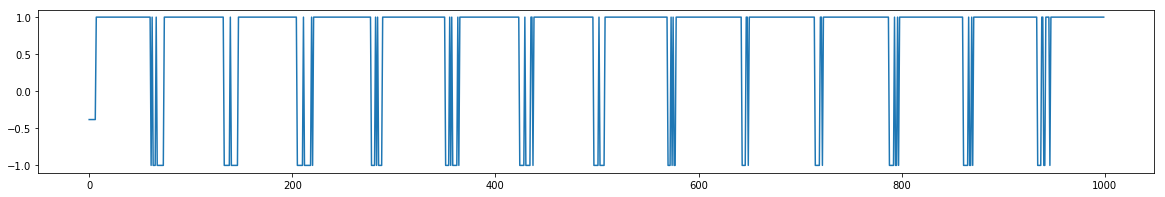

In [100]:
output = np.argmax(out[0], axis=1)
output_wav = mu_law_decode(output, 256)
print(output[:10])
print(output_wav[:10])

x = np.arange(0, 16000)
plt.figure(figsize=[20, 3]); plt.plot(x[:1000], output_wav.numpy()[:1000])